# Imports and Configs

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import numpy as np
from collections import defaultdict
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
torch.manual_seed(42)

# Data Loading

In [4]:
transform_test = transforms.Compose([
    transforms.Resize(224), # Imagenet requires 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [5]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified


In [20]:
# testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
all_indices = torch.randperm(len(testset))[:100].tolist()
test_subset = Subset(testset, all_indices)
testloader = DataLoader(test_subset, batch_size=16, shuffle=False, num_workers=2)

# Model Loading

In [21]:
def get_model():
    model = torchvision.models.resnet18(pretrained=True)

    # Modify final layer for 10 classes
    model.fc = nn.Linear(model.fc.in_features, 10)

    return model

In [22]:
def load_model(model_path):
    model = get_model()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

model_path = "./models/resnet18_cifar10.pth"
model = load_model(model_path)

/tmp/ipykernel_1255/3171478179.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


# First-Order Methods

## FGSM

In [23]:
def fgsm_attack_iterative(model, images, labels, epsilon=0.03, **attack_kwargs):
    """
    FGSM attack that yields results (always 1 iteration only).

    Yields:
        (adv_images, iteration, num_queries, extra_info)
    """
    images = images.clone().detach()

    images.requires_grad_(True)

    outputs = model(images)
    loss = torch.nn.CrossEntropyLoss()(outputs, labels)

    model.zero_grad()
    loss.backward()

    grad_sign = images.grad.sign()
    adv_images = (images + epsilon * grad_sign).detach()

    yield adv_images.detach(), 0, images.shape[0], {'loss': loss.item()}

## PGD

In [24]:
# def pgd_attack(model, images, labels, epsilon=0.03, alpha=0.01, iterations=10):
#     orig_images = images.clone().detach()
#     adv_images = images.clone().detach()
#     queries = 0

#     adv_images = adv_images + torch.empty_like(adv_images).uniform_(-epsilon, epsilon)
#     adv_images = adv_images.detach()

#     for _ in range(iterations):
#         adv_images.requires_grad = True

#         outputs = model(adv_images)
#         queries += images.shape[0]

#         loss = torch.nn.CrossEntropyLoss()(outputs, labels)
#         model.zero_grad()
#         loss.backward()

#         grad_sign = adv_images.grad.sign()

#         with torch.no_grad():
#             adv_images = adv_images + alpha * grad_sign
#             delta = torch.clamp(adv_images - orig_images, min=-epsilon, max=epsilon)
#             adv_images = (orig_images + delta).detach()

#     return adv_images, queries

In [25]:
def pgd_attack_iterative(model, images, labels, epsilon=0.3, alpha=0.01, steps=10, **kwargs):
    """
    PGD attack that yields intermediate results.

    Yields:
        (adv_images, iteration, num_queries, extra_info) at each step
    """
    adv_images = images.clone().detach()

    for step in range(steps):
        adv_images.requires_grad_(True)

        outputs = model(adv_images)
        loss = torch.nn.functional.cross_entropy(outputs, labels)

        grad = torch.autograd.grad(loss, adv_images)[0]

        # PGD step
        adv_images = adv_images.detach() + alpha * grad.sign()
        delta = torch.clamp(adv_images - images, min=-epsilon, max=epsilon)
        adv_images = images + delta

        yield adv_images.detach(), step, images.shape[0], {'loss': loss.item()}

# Zeroth-Order Methods

## SPSA

In [51]:
def spsa_attack_iterative_v2(model, images, labels, epsilon=0.3, alpha=0.01, steps=10, 
                            spsa_delta=1e-4, **kwargs):
    """
    Improved SPSA attack with proper gradient estimation.
    """
    batch_size = images.shape[0]
    adv_images = images.clone().detach()
    total_queries = 0
    
    for step in range(steps):
        # Generate Rademacher random directions
        direction = torch.randint_like(adv_images, 0, 2, dtype=adv_images.dtype) * 2 - 1
        
        with torch.no_grad():
            # Perturbed samples
            # adv_plus = torch.clamp(adv_images + spsa_delta * direction, 0, 1)
            # adv_minus = torch.clamp(adv_images - spsa_delta * direction, 0, 1)

            adv_plus = adv_images + spsa_delta * direction
            adv_minus = adv_images - spsa_delta * direction
            
            # Model evaluations
            outputs_plus = model(adv_plus)
            outputs_minus = model(adv_minus)
            
            # Loss computation (per sample)
            loss_plus = F.cross_entropy(outputs_plus, labels, reduction='none')
            loss_minus = F.cross_entropy(outputs_minus, labels, reduction='none')
            
            total_queries += 2 * batch_size
            
            # SPSA gradient approximation
            # Reshape to enable broadcasting: [batch_size] -> [batch_size, 1, 1, 1]
            loss_diff = (loss_plus - loss_minus).view(batch_size, *([1] * (len(adv_images.shape) - 1)))
            grad_estimate = loss_diff * direction / (2 * spsa_delta)
            
            # Gradient ascent step (maximize loss for attack)
            adv_images = adv_images + alpha * grad_estimate.sign()
            
            # Project to epsilon-ball
            delta = torch.clamp(adv_images - images, -epsilon, epsilon)
            # adv_images = torch.clamp(images + delta, 0, 1)
            adv_images = images + delta
        
        yield adv_images.detach(), step, total_queries, {
            'loss': loss_plus.mean().item(),
            'queries_this_step': 2 * batch_size
        }

In [62]:
def spsa_attack(model, images, labels, epsilon=0.3, alpha=0.01, num_iterations=100, 
                c=0.1, gamma=0.166, a=0.25, A=10):
    """
    SPSA (Simultaneous Perturbation Stochastic Approximation) Attack
    
    Args:
        model: PyTorch model to attack
        images: Input images tensor [batch_size, channels, height, width]
        labels: True labels tensor [batch_size]
        epsilon: Maximum perturbation magnitude (L∞ norm)
        alpha: Learning rate scaling factor
        num_iterations: Number of SPSA iterations
        c: Perturbation magnitude for gradient estimation
        gamma: Decay rate for perturbation magnitude
        a: Decay rate for step size
        A: Stability constant for step size
        targeted: Whether to perform targeted attack
        target_labels: Target labels for targeted attack [batch_size]
    
    Returns:
        adv_images: Adversarial images tensor
        success_rate: Attack success rate
    """
    
    batch_size = images.size(0)
    
    # Initialize adversarial images
    adv_images = images.clone().detach()
    
    # Set model to evaluation mode
    model.eval()
    
    for iteration in range(num_iterations):
        # Calculate adaptive parameters
        a_k = alpha / (A + iteration + 1) ** a
        c_k = c / (iteration + 1) ** gamma
        
        # Generate random perturbation directions (Rademacher distribution)
        delta = torch.randint_like(adv_images, low=0, high=2, dtype=torch.float32) * 2 - 1
        
        # Create positive and negative perturbations
        adv_plus = adv_images + c_k * delta
        adv_minus = adv_images - c_k * delta
        
        # Clamp to valid image range
        # adv_plus = torch.clamp(adv_plus, 0, 1)
        # adv_minus = torch.clamp(adv_minus, 0, 1)

        adv_plus = adv_plus
        adv_minus = adv_minus
        
        # Get model predictions
        with torch.no_grad():
            logits_plus = model(adv_plus)
            logits_minus = model(adv_minus)
        
        # Maximize loss for true class
        loss_plus = F.cross_entropy(logits_plus, labels, reduction='none')
        loss_minus = F.cross_entropy(logits_minus, labels, reduction='none')

        gradient_estimate = (loss_plus - loss_minus).view(-1, 1, 1, 1) * delta / (2 * c_k)

        # Update adversarial images
        adv_images = adv_images + a_k * torch.sign(gradient_estimate)
        
        # Project to epsilon ball (L∞ constraint)
        perturbation = adv_images - images
        perturbation = torch.clamp(perturbation, -epsilon, epsilon)
        adv_images = images + perturbation
        
        # Clamp to valid image range
        # adv_images = torch.clamp(adv_images, 0, 1)

        yield adv_images, iteration, 2 * batch_size, {}

## Zero Order PGD

In [ ]:

def normalize(tensor, mode="l_inf"):
    if tensor.dim() == 3:
        tensor = tensor.unsqueeze(0)  # [C, H, W] -> [1, C, H, W]

    if mode == "l_inf":
        return tensor / tensor.abs().view(tensor.size(0), -1).max(dim=1)[0].view(-1, 1, 1, 1)
    elif mode == "l_2":
        return tensor / tensor.view(tensor.size(0), -1).norm(p=2, dim=1).view(-1, 1, 1, 1)

    return tensor




def project_to_ball(tensor, center, radius, mode="l_inf"):
    if tensor.dim() == 3:
        tensor = tensor.unsqueeze(0)
        center = center.unsqueeze(0)

    if mode == "l_inf":
        return torch.clamp(tensor, center - radius, center + radius)
    elif mode == "l_2":
        diff = tensor - center
        norms = diff.view(diff.size(0), -1).norm(p=2, dim=1, keepdim=True)
        scale = torch.clamp(radius / norms, max=1.0).view(-1, 1, 1, 1)
        return center + diff * scale

    return tensor



def loss_fn(model, x, labels):
    if x.dim() == 3:
        x = x.unsqueeze(0)
    if isinstance(labels, int):
        labels = torch.tensor([labels], dtype=torch.long, device=x.device)
    return torch.nn.functional.cross_entropy(model(x), labels, reduction='none')

def estimate_gradient_batched(f, x, h=1e-3, num_dirs=20):
    """
    Estimates the gradient of f at batched inputs x using finite differences in random directions.

    Args:
        f: A function that maps [B, C, H, W] -> [B] loss values (per sample)
        x: Tensor of shape [B, C, H, W]
        h: Finite difference step size
        num_dirs: Number of random directions per sample

    Returns:
        grad_estimates: Tensor of shape [B, C, H, W]
    """
    if x.dim() == 3:
        x = x.unsqueeze(0)  # single image -> batch

    B, C, H, W = x.shape
    device = x.device

    # Generate normalized random directions for each sample
    directions = torch.randn(B, num_dirs, C, H, W, device=device)
    directions = directions / directions.view(B, num_dirs, -1).norm(p=2, dim=2).clamp(min=1e-8).view(B, num_dirs, 1, 1, 1)

    # Create perturbations
    x_expanded = x.unsqueeze(1).expand(-1, num_dirs, -1, -1, -1)  # [B, num_dirs, C, H, W]
    x_plus = x_expanded + h * directions
    x_minus = x_expanded - h * directions

    # Flatten into batch of [2 * B * num_dirs, C, H, W]
    x_both = torch.cat([x_plus, x_minus], dim=1).reshape(2 * B * num_dirs, C, H, W)

    with torch.no_grad():
        losses = f(x_both)  # returns shape [2 * B * num_dirs]

    # Split back into shape [B, num_dirs]
    f_plus = losses[:B * num_dirs].view(B, num_dirs)
    f_minus = losses[B * num_dirs:].view(B, num_dirs)

    # Compute gradient estimates per sample
    grad_estimates = ((f_plus - f_minus).view(B, num_dirs, 1, 1, 1) * directions).mean(dim=1) / (2 * h)

    return grad_estimates




def zero_pgd_attack(
    model,
    original_images,
    true_labels,
    steps=30,
    lr=0.01,
    delta=1e-3,
    epsilon=1e-1,
    num_dirs=100,
    targeted=False,
):
    """
    Batched ZO-PGD attack.

    Args:
        original_images: [B, C, H, W]
        true_labels: [B] tensor of ground truth class indices
    Returns:
        x_adv: Adversarial images of shape [B, C, H, W]
        final_preds: Final predictions of the adversarial examples [B]
    """



    def loss_wrapper(z_batch):
        B_dirs = z_batch.size(0)
        B = true_labels.size(0)

        if B_dirs % B != 0:
            raise ValueError("Mismatch between expanded batch size and label batch")

        repeat_factor = B_dirs // B
        labels = true_labels.repeat_interleave(repeat_factor)

        z_batch_resized = F.interpolate(z_batch, size=(224, 224), mode='bilinear', align_corners=False)
        return loss_fn(model, z_batch_resized, labels)

    device = original_images.device
    x = original_images.clone().detach().to(device)
    x_adv = x.clone().detach().to(device)

    for step in range(steps):
        grad = estimate_gradient_batched(loss_wrapper, x_adv, h=delta, num_dirs=num_dirs)
        grad = normalize(grad, mode="l_inf")

        x_adv = x_adv + lr * grad
        x_adv = project_to_ball(x_adv, x, radius=epsilon, mode="l_inf")
        x_adv = torch.clamp(x_adv, -1, 1)


        #return x_adv, preds
        yield x_adv, step, 2 * x_adv.size(0) * num_dirs, {}

def zero_pgd_attack_adam(
    model,
    original_images,
    true_labels,
    steps=30,
    lr=0.01,
    delta=1e-3,
    epsilon=1e-1,
    num_dirs=100,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    targeted=False
):



    def loss_wrapper(z_batch):
        B_dirs = z_batch.size(0)
        B = true_labels.size(0)

        if B_dirs % B != 0:
            raise ValueError("Mismatch between expanded batch size and label batch")

        repeat_factor = B_dirs // B
        labels = true_labels.repeat_interleave(repeat_factor)

        z_batch_resized = F.interpolate(z_batch, size=(224, 224), mode='bilinear', align_corners=False)
        return loss_fn(model, z_batch_resized, labels)


    device = original_images.device
    x = original_images.clone().detach().to(device)
    x_adv = x.clone().detach().to(device)

    m = torch.zeros_like(x_adv)
    v = torch.zeros_like(x_adv)

    for step in range(1, steps + 1):
        grad = estimate_gradient_batched(loss_wrapper, x_adv, h=delta, num_dirs=num_dirs)
        grad = normalize(grad, mode="l_inf")

        if targeted:
            grad = -grad

        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad.pow(2)

        m_hat = m / (1 - beta1 ** step)
        v_hat = v / (1 - beta2 ** step)

        step_update = lr * m_hat / (v_hat.sqrt() + eps)
        x_adv = x_adv + step_update
        x_adv = project_to_ball(x_adv, x, radius=epsilon, mode="l_inf")
        x_adv = torch.clamp(x_adv, -1, 1)



        #return x_adv, preds
        yield x_adv, step, 2 * x_adv.size(0) * num_dirs, {}


## ZOO

In [ ]:

def l2_norm_squared_gradient(a,b):
    return 2 * (a - b)



def linf_norm_subgradient(a, b):
    diff = a - b
    abs_diff = diff.abs()
    # max over all pixels per sample
    max_vals = abs_diff.view(abs_diff.size(0), -1).max(dim=1)[0].view(-1, 1, 1, 1)
    mask = (abs_diff == max_vals)
    return mask.float() * diff.sign()



def regularization_gradient(x, y, mode="l_2"):
  if mode == "l_2":
    return l2_norm_squared_gradient(x, y)
  elif mode == "l_inf":
    return linf_norm_subgradient(x, y)
  else:
    raise ValueError("Invalid mode. Must be 'l_2' or 'l_inf'.")


def batched_margin_loss(model, x, labels, kappa=0.0):
    """
    logits: [B, K] - raw logits
    labels: [B] - true or target class indices
    kappa: float - confidence margin (e.g., 0.0 for standard CW loss)

    Returns: loss tensor of shape [B]
    """
    with torch.no_grad():
        logits = model(x)

    B, K = logits.shape
    device = logits.device

    log_probs = F.log_softmax(logits, dim=1)  # [B, K]

    # Gather log probs of the target labels
    log_true = log_probs[torch.arange(B, device=device), labels]  # [B]

    # Mask out the true class
    mask = torch.ones_like(log_probs, dtype=torch.bool)
    mask.scatter_(1, labels.view(-1, 1), False)

    # Replace true class logits with very low value before max
    log_probs_masked = log_probs.masked_fill(~mask, float('-inf'))

    # Max over other classes
    log_max_other = log_probs_masked.max(dim=1).values  # [B]

    margin = log_true - log_max_other  # [B]
    loss = torch.clamp(margin, min=-kappa)

    return loss  # per-example margin loss




def zoo_attack(
    model,
    original_images,
    true_labels,
    steps=30,
    alpha=1.0,
    delta=1e-3,
    num_dirs=100,
    lr=0.1,
    targeted=False
):
    def loss_wrapper(z_batch):
        B_dirs = z_batch.size(0)
        B = true_labels.size(0)
        repeat_factor = B_dirs // B
        labels = true_labels.repeat_interleave(repeat_factor)
        z_batch_resized = F.interpolate(z_batch, size=(224, 224), mode='bilinear', align_corners=False)
        return batched_margin_loss(model, z_batch_resized, labels)

    device = original_images.device
    x = original_images.clone().detach().to(device)
    x_adv = x.clone().detach().to(device)

    for step in range(steps):
        grad_loss = estimate_gradient_batched(loss_wrapper, x_adv, h=delta, num_dirs=num_dirs)
        grad_reg = regularization_gradient(x_adv, x, mode="l_2")
        grad = grad_loss + alpha * grad_reg


        x_adv = x_adv - lr * grad
        x_adv = torch.clamp(x_adv, -1, 1)

        #return x_adv, preds
        yield x_adv, step, 2 * x_adv.size(0) * num_dirs, {}


def zoo_attack_adam(
    model,
    original_images,
    true_labels,
    steps=500,
    alpha=1.0,
    delta=1e-3,
    num_dirs=100,
    lr=0.01,
    beta1=0.9,
    beta2=0.999,
    eps=1e-8,
    targeted=False
):
    def loss_wrapper(z_batch):
        B_dirs = z_batch.size(0)
        B = true_labels.size(0)
        repeat_factor = B_dirs // B
        labels = true_labels.repeat_interleave(repeat_factor)
        z_batch_resized = F.interpolate(z_batch, size=(224, 224), mode='bilinear', align_corners=False)
        return batched_margin_loss(model, z_batch_resized, labels)

    def loss_wrapper(z_batch):
        B_dirs = z_batch.size(0)
        B = true_labels.size(0)
        repeat_factor = B_dirs // B
        labels = true_labels.repeat_interleave(repeat_factor)

        z_batch_resized = F.interpolate(z_batch, size=(224, 224), mode='bilinear', align_corners=False)
        return batched_margin_loss(model, z_batch_resized, labels)


    device = original_images.device
    x = original_images.clone().detach().to(device)
    x_adv = x.clone().detach()
    m = torch.zeros_like(x_adv)
    v = torch.zeros_like(x_adv)

    for step in range(1, steps + 1):
        grad_loss = estimate_gradient_batched(loss_wrapper, x_adv, h=delta, num_dirs=num_dirs)
        grad_reg = regularization_gradient(x_adv, x, mode="l_2")
        grad = grad_loss + alpha * grad_reg

        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad.pow(2)

        m_hat = m / (1 - beta1 ** step)
        v_hat = v / (1 - beta2 ** step)

        x_adv = x_adv - lr * m_hat / (v_hat.sqrt() + eps)
        x_adv = torch.clamp(x_adv, -1, 1)

        x_resized = F.interpolate(x_adv, size=(224, 224), mode='bilinear', align_corners=False)

        #return x_adv, preds
        yield x_adv, step, 2 * x_adv.size(0) * num_dirs, {}




## Bandits

In [ ]:

def estimate_gradient_bandit_batched(f, x, v, h1, h2, num_dirs=20):
    """
    Estimate bandit gradient for a batch of images.
    Inputs:
        x, v: [B, C, H, W]
    Returns:
        grad_estimates: [B, C, H, W]
    """
    if x.dim() == 3:
        x = x.unsqueeze(0)
        v = v.unsqueeze(0)

    B, C, H, W = x.shape
    device = x.device

    directions = torch.randn(B, num_dirs, C, H, W, device=device)
    directions = directions / directions.view(B, num_dirs, -1).norm(p=2, dim=2).clamp(min=1e-8).view(B, num_dirs, 1, 1, 1)

    q1 = v.unsqueeze(1) + h1 * directions
    q2 = v.unsqueeze(1) - h1 * directions

    x_plus = x.unsqueeze(1) + h2 * q2
    x_minus = x.unsqueeze(1) + h2 * q1
    batch = torch.cat([x_plus, x_minus], dim=1).reshape(2 * B * num_dirs, C, H, W)

    with torch.no_grad():
        losses = f(batch)

    f_plus = losses[:B * num_dirs].view(B, num_dirs)
    f_minus = losses[B * num_dirs:].view(B, num_dirs)

    grad_estimates = ((f_plus - f_minus).view(B, num_dirs, 1, 1, 1) * directions).mean(dim=1) / (h1 * h2)
    return grad_estimates





def bandit_l2_attack(
    model, original_images, true_labels,
    steps=500, lr=0.5, eta=0.1, delta=1e-2, epsilon=1e-2, num_dirs=100
):
    def loss_wrapper(z_batch):
        B_dirs = z_batch.size(0)
        B = true_labels.size(0)
        repeat_factor = B_dirs // B
        labels = true_labels.repeat_interleave(repeat_factor)
        z_batch_resized = F.interpolate(z_batch, size=(224, 224), mode='bilinear', align_corners=False)
        return loss_fn(model, z_batch_resized, labels)

    device = original_images.device
    x = original_images.clone().detach().to(device)
    x_adv = x.clone().detach()
    v = torch.zeros_like(x)

    for step in range(steps):
        grad = estimate_gradient_bandit_batched(loss_wrapper, x_adv, v, h1=delta, h2=epsilon, num_dirs=num_dirs)
        v = v + eta * grad
        g = normalize(v, mode="l_2")
        x_adv = x_adv + lr * g
        x_adv = project_to_ball(x_adv, x, radius=epsilon, mode="l_2")
        x_adv = torch.clamp(x_adv, -1, 1)

        #return x_adv, preds
        yield x_adv, step, 2 * x_adv.size(0) * num_dirs, {}



def bandit_linf_attack(
    model, original_images, true_labels,
    steps=500, lr=0.5, eta=0.1, delta=1e-2, epsilon=0.05, num_dirs=100
):
    def loss_wrapper(z_batch):
        B_dirs = z_batch.size(0)
        B = true_labels.size(0)
        repeat_factor = B_dirs // B
        labels = true_labels.repeat_interleave(repeat_factor)
        z_batch_resized = F.interpolate(z_batch, size=(224, 224), mode='bilinear', align_corners=False)
        return loss_fn(model, z_batch_resized, labels)

    device = original_images.device
    x = original_images.clone().detach().to(device)
    x_adv = x.clone().detach()
    v = torch.zeros_like(x)

    for step in range(steps):
        grad = estimate_gradient_bandit_batched(loss_wrapper, x_adv, v, h1=delta, h2=epsilon, num_dirs=num_dirs)

        # Exponentiated Gradient update
        p = (v + 1.0) / 2.0
        exp_up = torch.exp(eta * grad)
        exp_down = torch.exp(-eta * grad)
        Z = p * exp_up + (1 - p) * exp_down + 1e-8
        p = p * exp_up / Z
        v = 2 * p - 1

        x_adv = x_adv + lr * v
        x_adv = project_to_ball(x_adv, x, radius=epsilon, mode="l_inf")
        x_adv = torch.clamp(x_adv, -1, 1)


        yield x_adv, step, 2 * x_adv.size(0) * num_dirs, {}


## Square Attack

In [ ]:

def square_loss(model, x, labels):
    """
    Margin loss: L(f(x), y) = f_y(x) - max_{k ≠ y} f_k(x), vectorized for batch.
    Inputs:
        x: [B, C, H, W], labels: [B]
    Returns:
        loss: [B] tensor
    """
    x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
    with torch.no_grad():
        logits = model(x_resized)  # [B, K]

    B = logits.size(0)
    correct_logits = logits[torch.arange(B), labels]  # [B]

    logits_masked = logits.clone()
    logits_masked[torch.arange(B), labels] = float('-inf')  # mask true class
    max_wrong_logits = logits_masked.max(dim=1).values  # [B]

    return correct_logits - max_wrong_logits  # [B]

def sample_direction_batch(epsilon, B, C, W, window_size, device):
    delta = torch.zeros((B, C, W, W), device=device)

    for i in range(B):
        r = random.randint(0, W - window_size)
        s = random.randint(0, W - window_size)
        for c in range(C):
            rho = random.choice([-2 * epsilon, 2 * epsilon])
            delta[i, c, r:r + window_size, s:s + window_size] = rho

    return delta


def h_schedule(step, N, image_size=96):
    """
    Returns square size h for step in Square Attack
    """
    base_sizes = [16, 14, 12, 10, 8, 6, 4]
    thresholds = [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0]

    for threshold, h in zip(thresholds, base_sizes):
        if step < threshold * N:
            return h




def square_attack(
    model,
    original_images,
    true_labels,
    steps=2000,
    epsilon=0.05,
):
    device = original_images.device
    x = original_images.clone().detach().to(device)
    x_adv = x.clone().detach()
    B, C, H, W = x.shape

    l = square_loss(model, x, true_labels)

    for step in range(steps):
        h = h_schedule(step, steps)
        delta = sample_direction_batch(epsilon, B, C, W, h, device=device)
        x_new = x_adv + delta
        x_new = project_to_ball(x_new, x, radius=epsilon, mode="l_inf")
        x_new = torch.clamp(x_new, -1, 1)

        l_new = square_loss(model, x_new, true_labels)

        improved = l_new < l
        x_adv[improved] = x_new[improved]
        l[improved] = l_new[improved]

        yield x_adv, step, 2 * x_adv.size(0), {}

# Evaluating Methods

## Evaluation Functions

In [28]:
# def evaluate_attack(model, dataloader, attack_fn, device, **attack_kwargs):
#     """
#     Evaluate model under adversarial attack.

#     Args:
#         model: Target model
#         dataloader: Data loader (images, labels)
#         attack_fn: Attack function with signature:
#                    adv_images = attack_fn(model, images, labels, **attack_kwargs)
#         device: Torch device
#         attack_kwargs: Parameters for attack function

#     Returns:
#         Dictionary of metrics
#     """
#     model.eval()

#     # Initialize metrics
#     clean_correct = 0
#     robust_correct = 0
#     adv_correct = 0
#     total = 0
#     attack_success = 0
#     l2_perturbations = []
#     linf_perturbations = []
#     confidences = []
#     time_elapsed = 0
#     total_queries = 0

#     for images, labels in tqdm(dataloader, desc="Evaluating"):
#         images, labels = images.to(device), labels.to(device)
#         batch_size = images.shape[0]
#         total += batch_size

#         # Clean accuracy
#         with torch.no_grad():
#             outputs = model(images)
#             preds_clean = outputs.argmax(dim=1)
#             clean_correct += (preds_clean == labels).sum().item()

#         # Generate adversarial examples
#         start_time = time.time()
#         adv_images, num_queries = attack_fn(model, images, labels, **attack_kwargs)
#         time_elapsed += time.time() - start_time
#         total_queries += num_queries

#         # Calculate perturbations
#         diff = (adv_images - images).view(batch_size, -1)
#         l2 = torch.norm(diff, p=2, dim=1).cpu().numpy()
#         linf = torch.norm(diff, p=float('inf'), dim=1).cpu().numpy()
#         l2_perturbations.extend(l2)
#         linf_perturbations.extend(linf)

#         # Adversarial accuracy
#         with torch.no_grad():
#             outputs_adv = model(adv_images)
#             preds_adv = outputs_adv.argmax(dim=1)
#             adv_correct += (preds_adv == labels).sum().item()

#             # Confidence in misclassifications
#             wrong_mask = (preds_adv != labels)
#             if wrong_mask.any():
#                 wrong_conf = torch.softmax(outputs_adv[wrong_mask], 1).max(1)[0].cpu().numpy()
#                 confidences.extend(wrong_conf)

#         # Attack success rate
#         orig_correct_mask = (preds_clean == labels)
#         flipped = orig_correct_mask & (preds_adv != labels)
#         attack_success += flipped.sum().item()

#         # Robust accuracy
#         robust_correct += (orig_correct_mask & (preds_adv == labels)).sum().item()

#     # Calculate metrics
#     clean_acc = 100 * clean_correct / total
#     adv_acc = 100 * adv_correct / total
#     robust_acc = 100 * robust_correct / clean_correct if clean_correct > 0 else 0
#     success_rate = 100 * attack_success / clean_correct if clean_correct > 0 else 0
#     avg_l2 = np.mean(l2_perturbations) if l2_perturbations else 0
#     avg_linf = np.mean(linf_perturbations) if linf_perturbations else 0
#     avg_conf = np.mean(confidences) if confidences else 0
#     avg_time = time_elapsed / total

#     return {
#         "clean_accuracy": clean_acc,
#         "adversarial_accuracy": adv_acc,
#         "robust_accuracy": robust_acc,
#         "attack_success_rate": success_rate,
#         "avg_l2_perturbation": avg_l2,
#         "avg_linf_perturbation": avg_linf,
#         "avg_misclassification_confidence": avg_conf,
#         "avg_time": avg_time,
#         "num_queries": total_queries
#     }

In [29]:
def evaluate_iterative_attack(model, dataloader, attack_fn, device, **attack_kwargs):
    """
    Evaluate model under iterative adversarial attack with per-iteration metrics.

    Args:
        model: Target model
        dataloader: Data loader (images, labels)
        attack_fn: Attack function that yields intermediate results.
                   Should have signature: generator = attack_fn(model, images, labels, **attack_kwargs)
                   Each yielded item should be: (adv_images, iteration, num_queries, extra_info)
        device: Torch device
        attack_kwargs: Parameters for attack function

    Returns:
        Dictionary with per-iteration metrics and final summary
    """
    model.eval()

    # Track metrics per iteration
    iteration_metrics = defaultdict(lambda: {
        'clean_correct': 0, 'adv_correct': 0, 'robust_correct': 0,
        'total': 0, 'attack_success': 0, 'l2_perturbations': [],
        'linf_perturbations': [], 'confidences': [], 'queries': 0
    })

    total_time = 0
    max_iterations = 0

    for images, labels in tqdm(dataloader, desc="Evaluating iterative attack"):
        images, labels = images.to(device), labels.to(device)
        batch_size = images.shape[0]

        # Clean accuracy (computed once per batch)
        with torch.no_grad():
            outputs = model(images)
            preds_clean = outputs.argmax(dim=1)
            clean_correct_mask = (preds_clean == labels)

        # Run iterative attack
        start_time = time.time()
        attack_generator = attack_fn(model, images, labels, **attack_kwargs)

        for result in attack_generator:
            if len(result) == 4:
                adv_images, iteration, num_queries, extra_info = result
            else:
                adv_images, iteration, num_queries = result
                extra_info = {}

            max_iterations = max(max_iterations, iteration)

            # Update metrics for this iteration
            metrics = iteration_metrics[iteration]
            metrics['total'] += batch_size
            metrics['clean_correct'] += clean_correct_mask.sum().item()
            metrics['queries'] += num_queries

            # Calculate perturbations
            diff = (adv_images - images).view(batch_size, -1)
            l2 = torch.norm(diff, p=2, dim=1).cpu().numpy()
            linf = torch.norm(diff, p=float('inf'), dim=1).cpu().numpy()
            metrics['l2_perturbations'].extend(l2)
            metrics['linf_perturbations'].extend(linf)

            # Adversarial predictions
            with torch.no_grad():
                outputs_adv = model(adv_images)
                preds_adv = outputs_adv.argmax(dim=1)
                adv_correct_mask = (preds_adv == labels)

                metrics['adv_correct'] += adv_correct_mask.sum().item()

                # Robust accuracy (originally correct AND still correct)
                robust_mask = clean_correct_mask & adv_correct_mask
                metrics['robust_correct'] += robust_mask.sum().item()

                # Attack success (originally correct BUT now wrong)
                attack_success_mask = clean_correct_mask & (~adv_correct_mask)
                metrics['attack_success'] += attack_success_mask.sum().item()

                # Confidence in misclassifications
                wrong_mask = ~adv_correct_mask
                if wrong_mask.any():
                    wrong_conf = torch.softmax(outputs_adv[wrong_mask], 1).max(1)[0].cpu().numpy()
                    metrics['confidences'].extend(wrong_conf)

        total_time += time.time() - start_time

    # Calculate final metrics per iteration
    results = {}
    for iteration in range(max_iterations + 1):
        if iteration in iteration_metrics:
            m = iteration_metrics[iteration]
            clean_correct = m['clean_correct']

            results[f'iteration_{iteration}'] = {
                "clean_accuracy": 100 * clean_correct / m['total'] if m['total'] > 0 else 0,
                "adversarial_accuracy": 100 * m['adv_correct'] / m['total'] if m['total'] > 0 else 0,
                "robust_accuracy": 100 * m['robust_correct'] / clean_correct if clean_correct > 0 else 0,
                "attack_success_rate": 100 * m['attack_success'] / clean_correct if clean_correct > 0 else 0,
                "avg_l2_perturbation": np.mean(m['l2_perturbations']) if m['l2_perturbations'] else 0,
                "avg_linf_perturbation": np.mean(m['linf_perturbations']) if m['linf_perturbations'] else 0,
                "avg_misclassification_confidence": np.mean(m['confidences']) if m['confidences'] else 0,
                "total_queries": m['queries'],
                "iteration": iteration
            }

    # Add summary metrics
    if max_iterations >= 0:
        final_metrics = results[f'iteration_{max_iterations}']
        results['summary'] = {
            **final_metrics,
            "total_time": total_time,
            "avg_time_per_sample": total_time / iteration_metrics[max_iterations]['total'] if iteration_metrics[max_iterations]['total'] > 0 else 0,
            "max_iterations": max_iterations
        }

    return results

## Plotting Functions

In [30]:
def plot_evaluation_results(results, x_values, x_label):
    metrics_to_plot = [
        "adversarial_accuracy",
        "robust_accuracy",
        "attack_success_rate",
        "avg_l2_perturbation",
        "avg_linf_perturbation",
        "avg_misclassification_confidence",
        "avg_time_per_sample",
    ]

    n_metrics = len(metrics_to_plot)
    n_cols = 3
    n_rows = (n_metrics + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    axes = axes.flatten()

    for i, metric in enumerate(metrics_to_plot):
        axes[i].plot(x_values, [result[metric] for result in results], marker='o')
        axes[i].set_xlabel(x_label)
        axes[i].set_ylabel(metric)
        axes[i].set_title(f"{metric} vs {x_label}")
        axes[i].grid(True)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [45]:
def plot_iterative_results(results, figsize = (15, 10),
                          save_path = None,
                          exclude_metrics = None,
                          title_prefix: str = ""):
    """
    Plot metrics over iterations from iterative evaluation results.

    Args:
        results: Dictionary from evaluate_iterative_attack function
        figsize: Figure size (width, height)
        save_path: Path to save the plot (optional)
        exclude_metrics: List of metric names to exclude from plotting
        title_prefix: Prefix to add to the main title
    """
    if exclude_metrics is None:
        exclude_metrics = ['iteration', 'total_queries']  # Usually not interesting to plot

    # Extract iteration data (exclude 'summary')
    iteration_data = {k: v for k, v in results.items() if k.startswith('iteration_')}

    if not iteration_data:
        print("No iteration data found in results!")
        return

    # Get all available metrics (excluding specified ones)
    sample_iteration = list(iteration_data.values())[0]
    all_metrics = [k for k in sample_iteration.keys() if k not in exclude_metrics]

    # Sort iterations by number
    sorted_iterations = sorted(iteration_data.items(),
                              key=lambda x: int(x[0].split('_')[1]))

    # Extract data for plotting
    iterations = [int(k.split('_')[1]) for k, _ in sorted_iterations]

    plot_data = {}
    for metric in all_metrics:
        plot_data[metric] = [data[metric] for _, data in sorted_iterations]

    # Create subplot grid
    n_metrics = len(all_metrics)
    n_cols = 3  # 3 columns looks good for most cases
    n_rows = (n_metrics + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)

    # Flatten axes for easier indexing
    axes_flat = axes.flatten()

    # Define colors and styles for different metric types
    metric_styles = {
        'accuracy': {'color': '#2E86AB', 'linestyle': '-'},
        'success': {'color': '#A23B72', 'linestyle': '-'},
        'perturbation': {'color': '#F18F01', 'linestyle': '-'},
        'confidence': {'color': '#C73E1D', 'linestyle': '-'},
        'default': {'color': '#4A4A4A', 'linestyle': '-'}
    }

    def get_style(metric_name):
        """Get style based on metric name"""
        name_lower = metric_name.lower()
        if 'accuracy' in name_lower:
            return metric_styles['accuracy']
        elif 'success' in name_lower:
            return metric_styles['success']
        elif 'perturbation' in name_lower:
            return metric_styles['perturbation']
        elif 'confidence' in name_lower:
            return metric_styles['confidence']
        else:
            return metric_styles['default']

    # Plot each metric
    for i, metric in enumerate(all_metrics):
        ax = axes_flat[i]

        values = plot_data[metric]
        style = get_style(metric)

        ax.plot(iterations, values,
                linewidth=2.5, markersize=6,
                **style)

        # Formatting
        ax.set_xlabel('Iteration', fontsize=11)
        ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=11)
        ax.grid(True, alpha=0.3)
        ax.set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')

        # Set x-axis to show all iterations
        ax.set_xticks(iterations[::max(1, len(iterations)//10)])  # Show ~10 ticks max

        # Format y-axis based on metric type
        if 'accuracy' in metric.lower() or 'rate' in metric.lower():
            ax.set_ylim(0, 105)  # Percentage metrics
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))
        elif 'confidence' in metric.lower():
            ax.set_ylim(0, 1.05)
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
        else:
            # Auto-scale for other metrics
            ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))

    # Hide unused subplots
    for i in range(n_metrics, len(axes_flat)):
        axes_flat[i].set_visible(False)

    # Main title
    main_title = f"{title_prefix}Attack Progress Over Iterations" if title_prefix else "Attack Progress Over Iterations"
    fig.suptitle(main_title, fontsize=16, fontweight='bold', y=0.95)

    # Add summary info
    if 'summary' in results:
        summary = results['summary']
        summary_text = (f"Final: {summary.get('attack_success_rate', 0):.1f}% success, "
                       f"{summary.get('robust_accuracy', 0):.1f}% robust, "
                       f"{summary.get('total_queries', 0):,} queries")
        fig.text(0.5, 0.02, summary_text, ha='center', fontsize=11,
                style='italic', color='#666666')

    plt.tight_layout()
    plt.subplots_adjust(top=0.90, bottom=0.08)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

In [46]:
def plot_comparison_results(results_dict,
                           metric: str = 'attack_success_rate',
                           figsize = (12, 8),
                           save_path = None):
    """
    Compare multiple attack results for a specific metric.

    Args:
        results_dict: Dictionary of {attack_name: results} pairs
        metric: Metric to compare
        figsize: Figure size
        save_path: Path to save the plot
    """
    plt.figure(figsize=figsize)

    colors = plt.cm.Set1(np.linspace(0, 1, len(results_dict)))

    for (attack_name, results), color in zip(results_dict.items(), colors):
        # Extract iteration data
        iteration_data = {k: v for k, v in results.items() if k.startswith('iteration_')}

        if not iteration_data:
            continue

        sorted_iterations = sorted(iteration_data.items(),
                                  key=lambda x: int(x[0].split('_')[1]))

        iterations = [int(k.split('_')[1]) for k, _ in sorted_iterations]
        values = [data.get(metric, 0) for _, data in sorted_iterations]

        plt.plot(iterations, values,
                linewidth=2.5, markersize=6,
                label=attack_name, color=color)

    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel(metric.replace('_', ' ').title(), fontsize=12)
    plt.title(f'Attack Comparison: {metric.replace("_", " ").title()}',
              fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)

    # Format y-axis
    if 'accuracy' in metric.lower() or 'rate' in metric.lower():
        plt.ylim(0, 105)
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Comparison plot saved to {save_path}")

    plt.show()

## FGSM - Epsilon Impact

In [33]:
results = []
epsilons = np.arange(0.0, 0.2, 0.01)
for epsilon in epsilons:
    results.append(evaluate_iterative_attack(model, testloader, fgsm_attack_iterative, device, **{"epsilon": epsilon})["summary"])

Evaluating iterative attack: 100%|██████████| 7/7 [00:00<00:00, 11.33it/s]


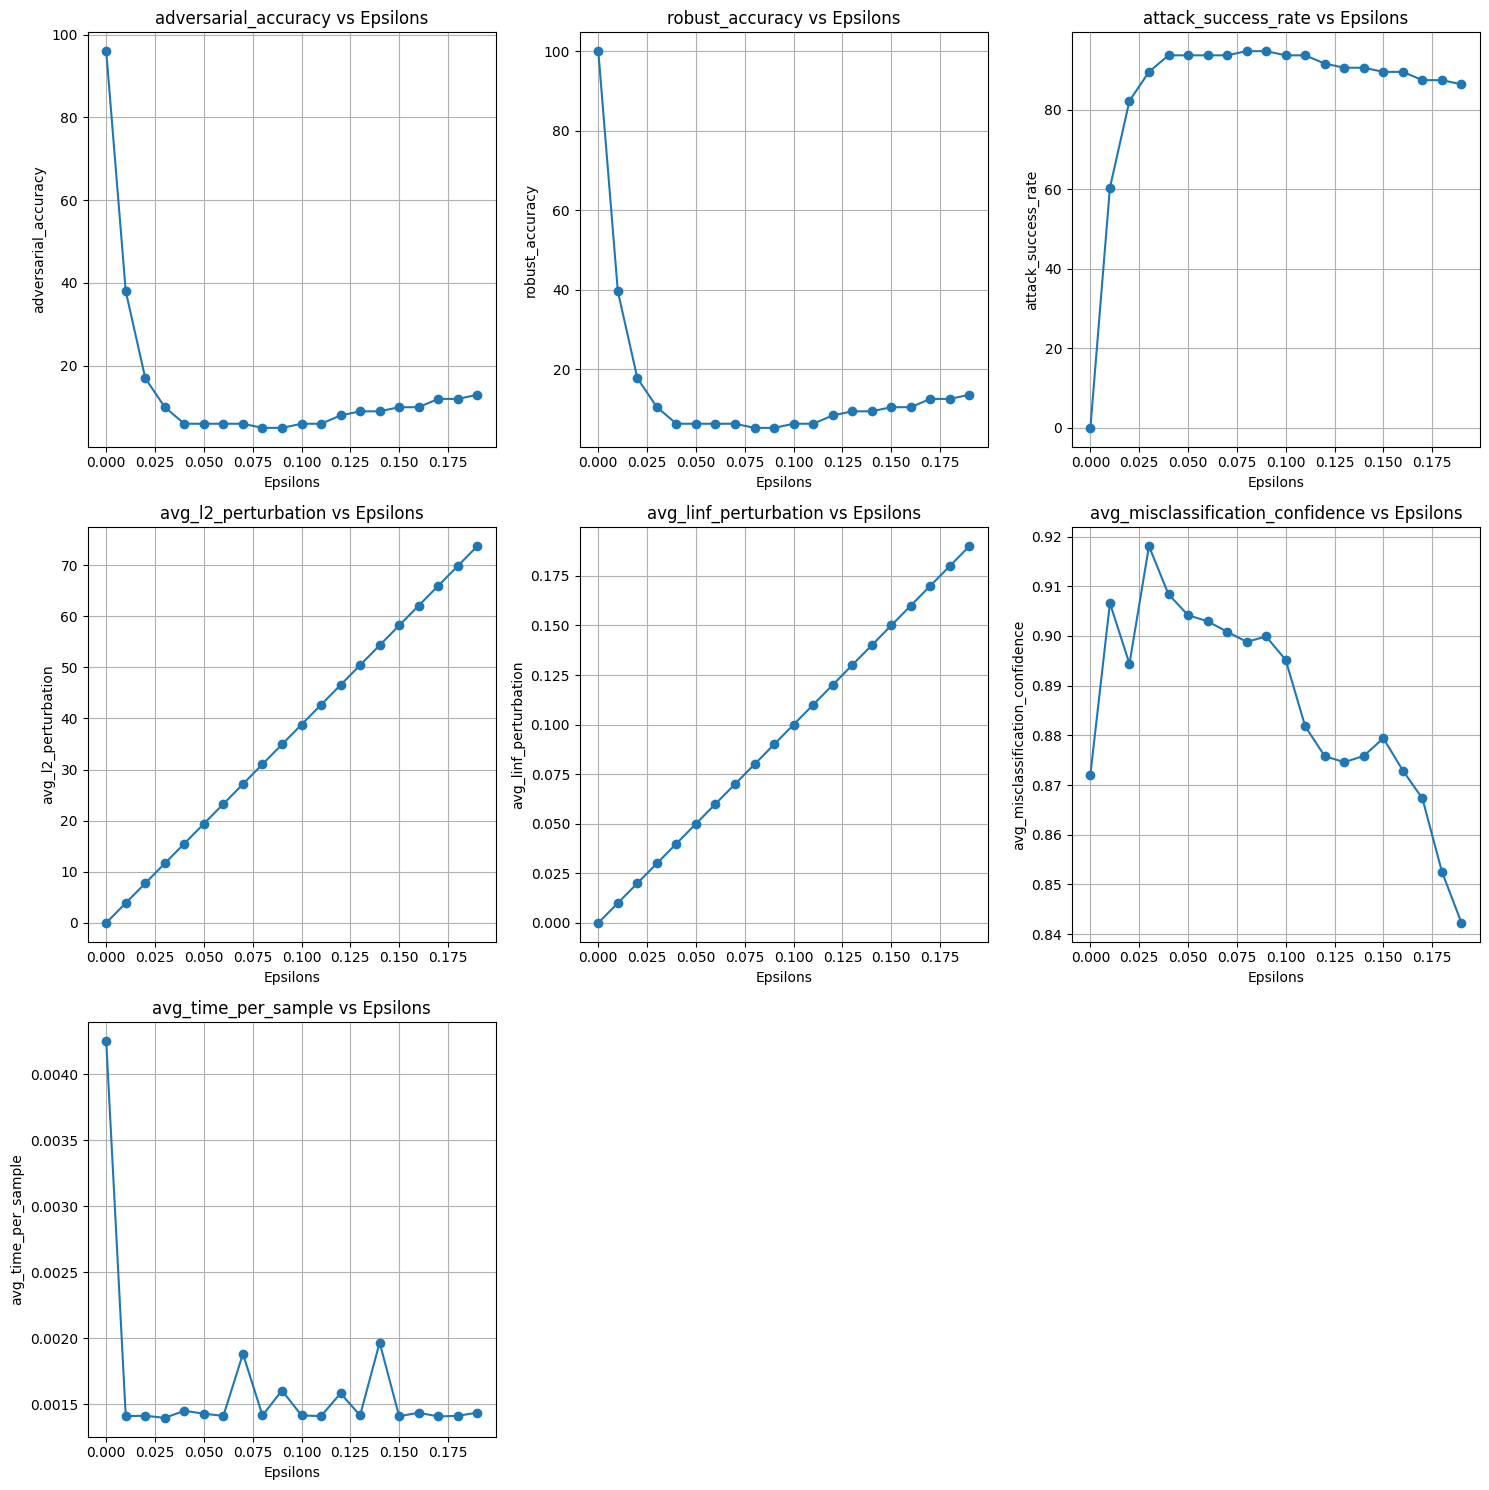

In [34]:
plot_evaluation_results(results, epsilons, "Epsilons")

## PGD - Iterations Impact

In [35]:
results = evaluate_iterative_attack(model, testloader, pgd_attack_iterative, device, **{"epsilon": 0.03, "alpha": 0.007, "steps": 50})

Evaluating iterative attack: 100%|██████████| 7/7 [00:05<00:00,  1.28it/s]


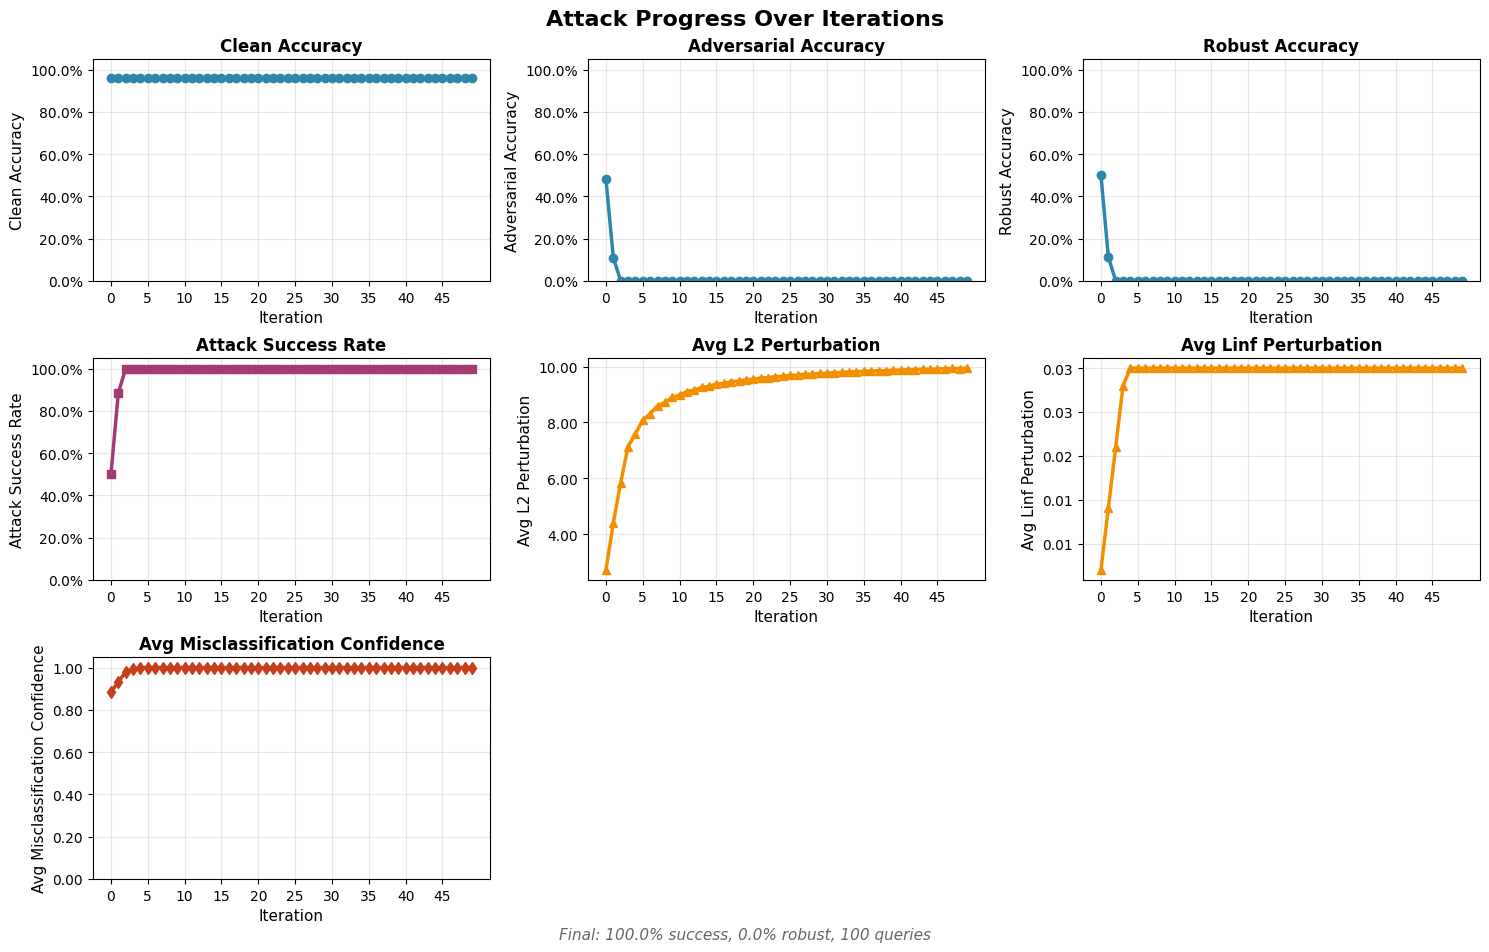

In [36]:
plot_iterative_results(results)

In [37]:
attacks = {
    "ε = 0.01, α = 0.005": {
        "attack_fn": pgd_attack_iterative,
        "kwargs": {"epsilon": 0.01, "alpha": 0.005, "steps": 10}
    },
    "ε = 0.02, α = 0.005": {
        "attack_fn": pgd_attack_iterative,
        "kwargs": {"epsilon": 0.02, "alpha": 0.005, "steps": 10}
    },
    "ε = 0.03, α = 0.005": {
        "attack_fn": pgd_attack_iterative,
        "kwargs": {"epsilon": 0.03, "alpha": 0.005, "steps": 10}
    },
    "ε = 0.01, α = 0.0075": {
        "attack_fn": pgd_attack_iterative,
        "kwargs": {"epsilon": 0.01, "alpha": 0.0075, "steps": 10}
    },
    "ε = 0.02, α = 0.0075": {
        "attack_fn": pgd_attack_iterative,
        "kwargs": {"epsilon": 0.02, "alpha": 0.0075, "steps": 10}
    },
    "ε = 0.03, α = 0.0075": {
        "attack_fn": pgd_attack_iterative,
        "kwargs": {"epsilon": 0.03, "alpha": 0.0075, "steps": 10}
    },
    "ε = 0.01, α = 0.01": {
        "attack_fn": pgd_attack_iterative,
        "kwargs": {"epsilon": 0.01, "alpha": 0.01, "steps": 10}
    },
    "ε = 0.02, α = 0.01": {
        "attack_fn": pgd_attack_iterative,
        "kwargs": {"epsilon": 0.02, "alpha": 0.01, "steps": 10}
    },
    "ε = 0.03, α = 0.01": {
        "attack_fn": pgd_attack_iterative,
        "kwargs": {"epsilon": 0.03, "alpha": 0.01, "steps": 10}
    },
}

results_dict = {}
for attack_name, attack_info in attacks.items():
    results_dict[attack_name] = evaluate_iterative_attack(model, testloader, attack_info["attack_fn"], device, **attack_info["kwargs"])

Evaluating iterative attack: 100%|██████████| 7/7 [00:01<00:00,  4.95it/s]


In [38]:
results_dict["ε = 0.5, α = 0.1"] = evaluate_iterative_attack(model, testloader, pgd_attack_iterative, device, **{"epsilon": 0.5, "alpha": 0.1, "steps": 10})

Evaluating iterative attack: 100%|██████████| 7/7 [00:01<00:00,  4.44it/s]


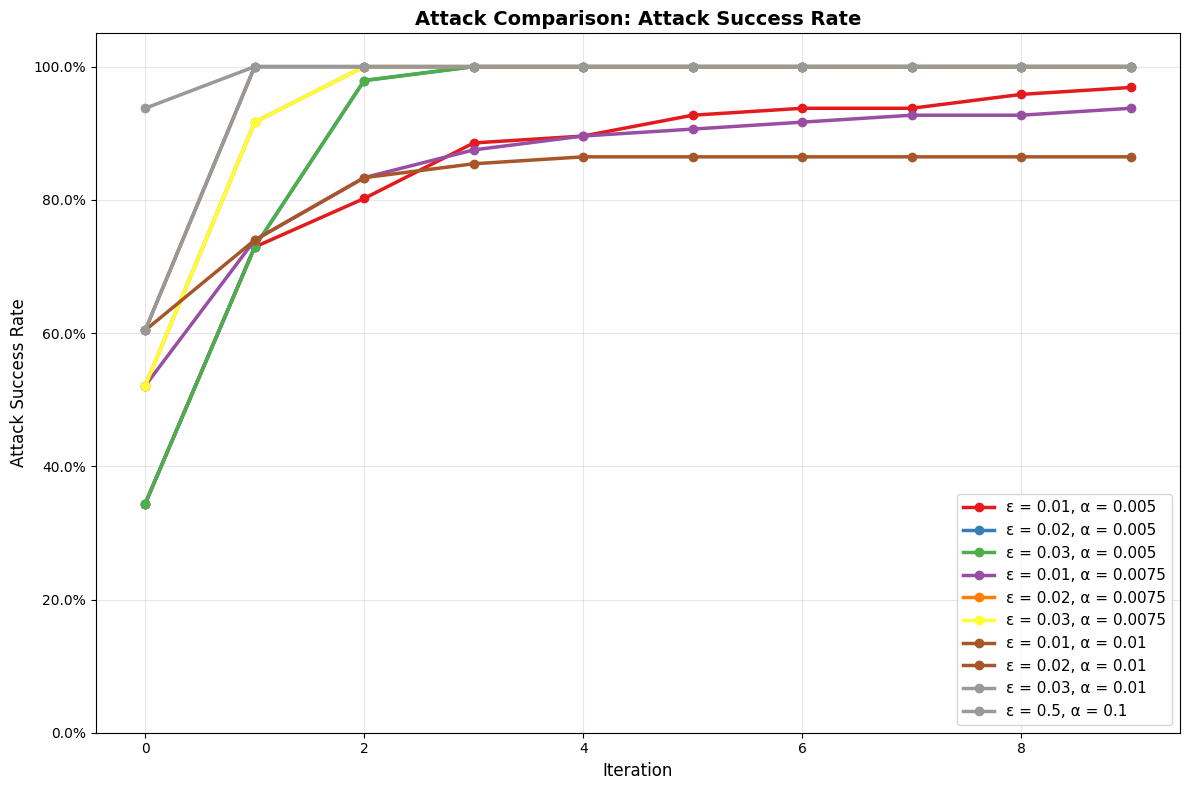

In [39]:
plot_comparison_results(results_dict)

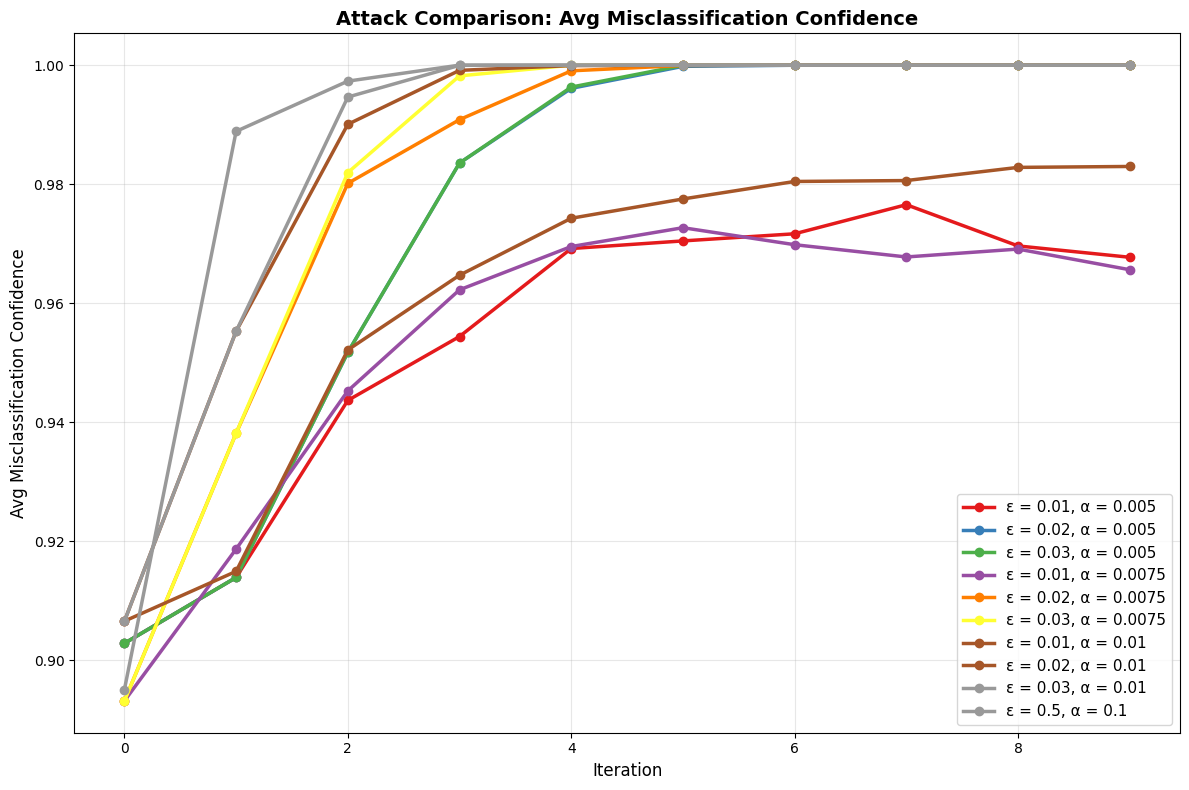

In [40]:
plot_comparison_results(results_dict, "avg_misclassification_confidence")

## SPSA Evaluation

In [65]:
results = evaluate_iterative_attack(model, testloader, spsa_attack, device, **{"num_iterations": 1000})

Evaluating iterative attack: 100%|██████████| 7/7 [01:28<00:00, 12.70s/it]


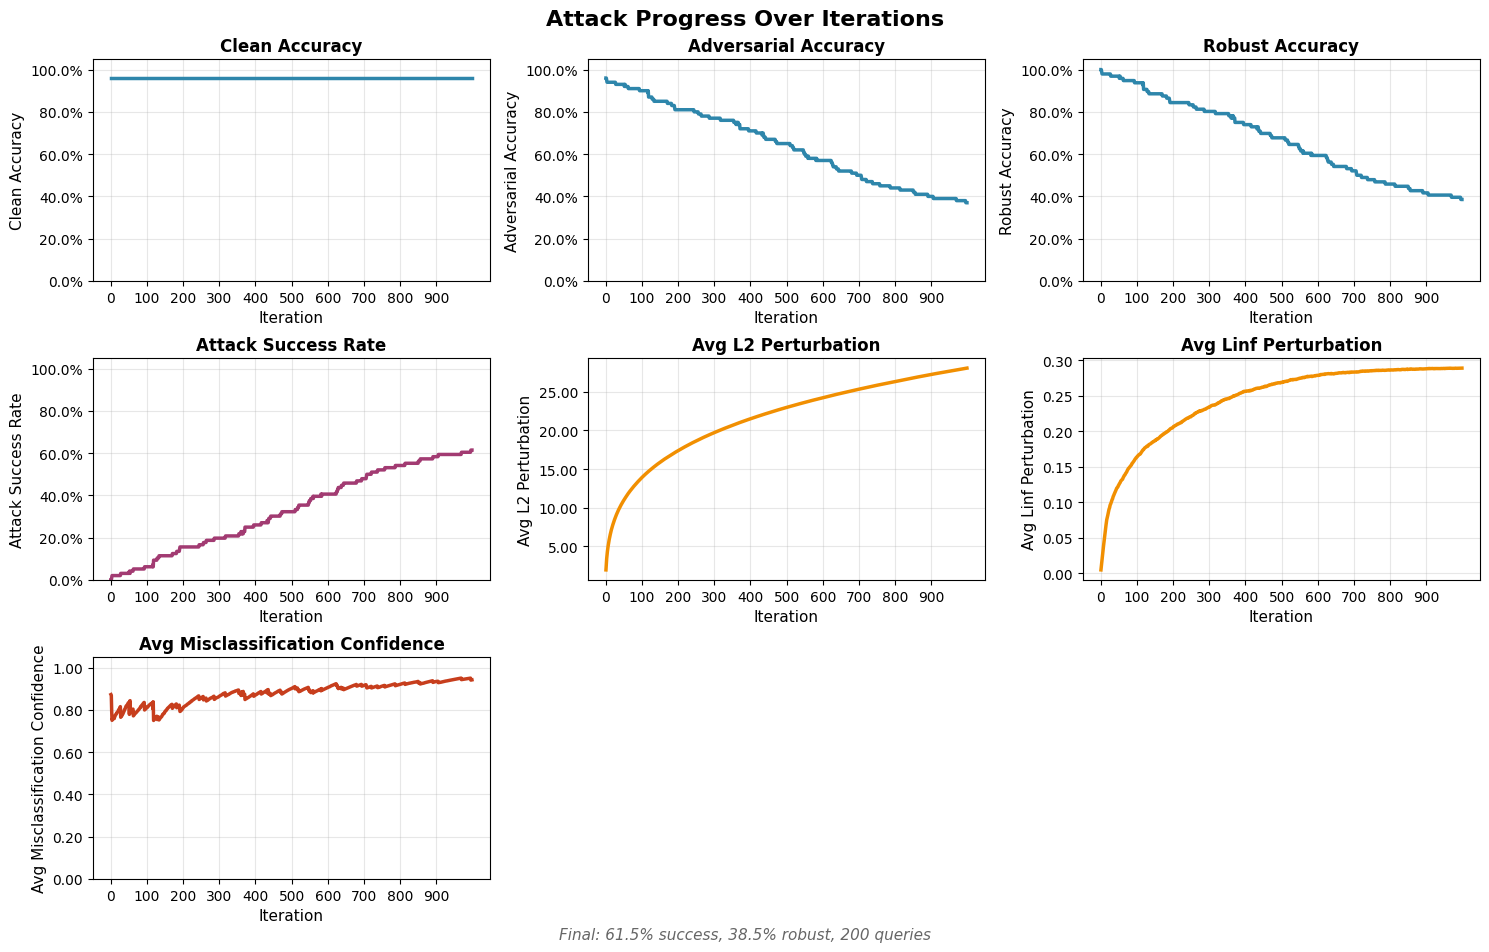

In [66]:
plot_iterative_results(results)